In [3]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk import trigrams
from nltk import bigrams
from collections import Counter

import pandas as pd
import numpy as np
import os
import time
import csv
import json
from typing import Dict, List, Optional, Union, cast
import requests
import prepare

import seaborn as sns
import matplotlib as plt

from bs4 import BeautifulSoup

df = prepare.wrangle_data()
df.info()

/Users/mindyshiben/codeup-data-science/nlp-project/prepare.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed'] = clean_tokens.apply(stem)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1627 entries, 0 to 2142
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1627 non-null   object
 1   language         1627 non-null   object
 2   readme_contents  1627 non-null   object
 3   stemmed          1627 non-null   object
 4   lemmatized       1627 non-null   object
 5   total_words      1627 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 89.0+ KB


/Users/mindyshiben/codeup-data-science/nlp-project/prepare.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized'] = clean_tokens.apply(lemmatize)
/Users/mindyshiben/codeup-data-science/nlp-project/prepare.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_words'] = df['lemmatized'].str.split().str.len()


#### prepare notes-
- talk about handling nulls, decision to drop langs with < 10 records
- talk about steps to get lemmatized column

In [4]:
df = prepare.wrangle_data()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1627 entries, 0 to 2142
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1627 non-null   object
 1   language         1627 non-null   object
 2   readme_contents  1627 non-null   object
 3   stemmed          1627 non-null   object
 4   lemmatized       1627 non-null   object
 5   total_words      1627 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 89.0+ KB


In [6]:
df.language.value_counts()

JavaScript    600
HTML          396
Python        320
R             162
Java          149
Name: language, dtype: int64

#### show counts and percentage of languages

- put this in function

In [7]:
langs = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
langs.columns = ['counts', 'percent']
langs

#maybe show this as histograms or count plots

,counts,percent
JavaScript,600,0.368777
HTML,396,0.243393
Python,320,0.196681
R,162,0.099570
Java,149,0.091580


In [8]:
#this is still prepare data, I am putting def clean into function, but can talk about
# how we picked the additional stop words (words that are high frequency words in 3 or more langs)

ADDITIONAL = ['The', 'I', 'This', 'app', 'run', 'project', 'user', 'use', 'mental', 'file', 'health',
       'create', 'using', 'page', 'code', 'also', 'data', 'help', 'used']
             
def clean(readme_contents):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL
    text = (unicodedata.normalize('NFKD', readme_contents)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    #words = re.sub(r'[^a-z\s]', '', text).split()
    words = re.sub (r'([^a-zA-Z ]+?)', "", text).split()
    #words = re.sub(r'[\D]', '', words).split()
    
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [9]:
#making dfs with clean function for all langs
JavaScript_words = clean(' '.join(df[df.language == 'JavaScript'].readme_contents))
HTML_words = clean(' '.join(df[df.language == 'HTML'].readme_contents))
Python_words = clean(' '.join(df[df.language == 'Python'].readme_contents))
Java_words = clean(' '.join(df[df.language == 'Java'].readme_contents))
R_words = clean(' '.join(df[df.language == 'R'].readme_contents))
all_words = clean(' '.join(df.readme_contents))

In [10]:
df.head()

,repo,language,readme_contents,stemmed,lemmatized,total_words
0,kharrigian/mental-health-datasets,Python,\n# Mental Health Datasets\n\nThe information ...,mental health datasetsth inform evolv list dat...,mental health datasetsthe information evolving...,2716
1,behavioral-data/Empathy-Mental-Health,Python,# Empathy in Text-based Mental Health Support\...,empathi textbas mental health supportthi repos...,empathy textbased mental health supportthis re...,400
2,stutisehgal/RASA-Mental-Health-Chatbot,Python,# RASA-Mental-Health-Chatbot\n\nMental health ...,rasamentalhealthchatbotment health chatbot dev...,rasamentalhealthchatbotmental health chatbot d...,55
3,openeobs/openeobs,Python,# Open-eObs\n[![Codacy Badge](https://api.coda...,openeobscodaci badgeutmmediumreferralamputmcon...,openeobscodacy badgeutmmediumreferralamputmcon...,223
4,kharrigian/mental-health-keywords,Python,# Mental Health Keywords for Twitter\n\nThis r...,mental health keyword twitterthi repositori co...,mental health keywords twitterthis repository ...,468


<AxesSubplot:>

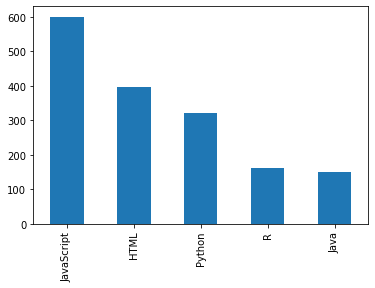

In [9]:
#this is redundant if you already show histograms or something
df.language.value_counts().plot(kind='bar')

<AxesSubplot:xlabel='language'>

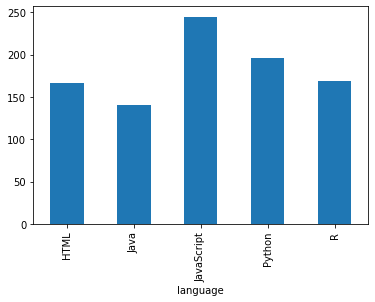

In [11]:
#shows total words distributed by langs. the graph below is better and we probably
# only need to use that one and not both
df.total_words.groupby(df.language).mean().plot(kind='bar')

In [12]:
#prep to make bins for the better visual
conditions = [(df.total_words > 171),
              (df.total_words >= 51) & (df.total_words <= 171),
              (df.total_words < 51)]
choices = ['high_count', 'med_count', 'low_count']

df['count_bin'] = np.select(conditions, choices)

In [13]:
df_plot = df.groupby(['language', 'count_bin']).size().reset_index().pivot(columns='count_bin', index='language', values=0)

<AxesSubplot:xlabel='language'>

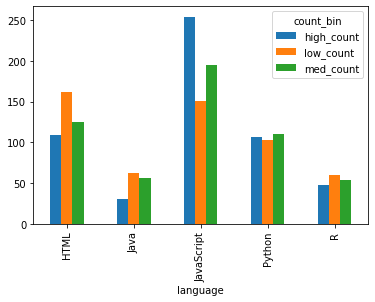

In [14]:
#I like this to show lang counts with bins

df_plot.plot(kind='bar')

### continue spot

In [20]:
#make dfs to show frequencies of words

JavaScript_freq = pd.Series(JavaScript_words).value_counts()
HTML_freq = pd.Series(HTML_words).value_counts()
Python_freq = pd.Series(Python_words).value_counts()
Java_freq = pd.Series(Java_words).value_counts()
R_freq = pd.Series(R_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [21]:
word_counts = (pd.concat([all_freq, JavaScript_freq, HTML_freq, Python_freq, 
                    Java_freq, R_freq], axis=1, sort=True)
                .set_axis(['all', 'JavaScript', 'HTML', 'Python', 'Java', 'R'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [22]:
#shows 20 top words- could show less is fine (important to note after the stop words have been removed)
#arranged by all words
word_counts.sort_values(by='all', ascending=False).head(20)

,all,JavaScript,HTML,Python,Java,R
build,1475,1268,90,54,41,22
npm,1348,1207,93,15,33,0
react,1302,1209,47,22,24,0
section,1130,843,219,42,8,18
test,1115,782,125,127,55,26
user,1043,482,216,187,141,17
feature,1015,520,147,264,63,21
install,973,573,113,218,36,33
need,928,539,160,135,48,46
make,919,554,178,124,40,23


In [23]:
#makes dfs for arranging top words by the diff langs to help compare
#if tops in some langs may be way different than tops in others
js_top = word_counts.sort_values(by='JavaScript', ascending=False).head(20)
html_top = word_counts.sort_values(by='HTML', ascending=False).head(20)
python_top = word_counts.sort_values(by='Python', ascending=False).head(20)
java_top = word_counts.sort_values(by='Java', ascending=False).head(20)
r_top = word_counts.sort_values(by='R', ascending=False).head(20)

In [24]:
#makes one df of the top 20 words in all dfs 
top_words = (pd.concat([js_top, html_top, python_top, java_top,
                    r_top], axis=0, sort=True)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

top_words.head()

,HTML,Java,JavaScript,Python,R,all
build,90,41,1268,54,22,1475
react,47,24,1209,22,0,1302
npm,93,33,1207,15,0,1348
section,219,8,843,42,18,1130
test,125,55,782,127,26,1115


In [25]:
#drops all as we don't need that to compare for next step
top_words= top_words.drop(columns=['all'])

In [26]:
#if you want to graph somehow, but not super necessary to include this
top_words

,HTML,Java,JavaScript,Python,R
build,90,41,1268,54,22
react,47,24,1209,22,0
npm,93,33,1207,15,0
section,219,8,843,42,18
test,125,55,782,127,26
...,...,...,...,...,...
width,66,22,129,31,76
folder,72,14,318,92,73
file,119,37,404,132,72
following,75,22,253,136,70


In [27]:
#this is what we used to determine other stop words for clean function. I
#don't think this needs to be here bc it wouldn't be right for flow,
#and we already took the unique word list to that function. just for you to have
#incase it helps with explaining the previous function
tops = top_words[top_words.index.value_counts() > 2]
tops.index.unique()

/var/folders/s4/hmz6ljm533vgpm_bhv59yw0m0000gn/T/ipykernel_79882/1118165033.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tops = top_words[top_words.index.value_counts() > 2]


Index(['need', 'feature', 'user', 'time', 'information', 'file'], dtype='object')

In [39]:
#just makes dfs of some of the most freq words. divided like this just to make graphs
#look nicer
#most_freq_700 is 700-799 words
#most_freq_800 is 800-999 words
#most_freq is is 1000+
most_freq_700 = word_counts[word_counts['all'] > 700] 
most_freq_700 = most_freq_700[most_freq_700['all'] < 800]
most_freq_800 = word_counts[word_counts['all'] >= 800]
most_freq_800 = most_freq_800[most_freq_800['all'] < 1000]
most_freq = word_counts[word_counts['all'] >= 1000]

In [42]:
#making dfs to look at these as a percentage and give each language
#equal weight looking at word importance as our records are evenly 
#distributed
word_perc = pd.DataFrame()
for col in most_freq.columns:
    word_perc = word_perc.append(most_freq[col].sort_values(ascending=False)/most_freq[col].sum())

word_perc_700 = pd.DataFrame()
for col in most_freq_700.columns:
    word_perc_700 = word_perc_700.append(most_freq_700[col].sort_values(ascending=False)/most_freq_700[col].sum())
    
word_perc_800 = pd.DataFrame()
for col in most_freq_800.columns:
    word_perc_800 = word_perc_800.append(most_freq_800[col].sort_values(ascending=False)/most_freq_800[col].sum())

<AxesSubplot:>

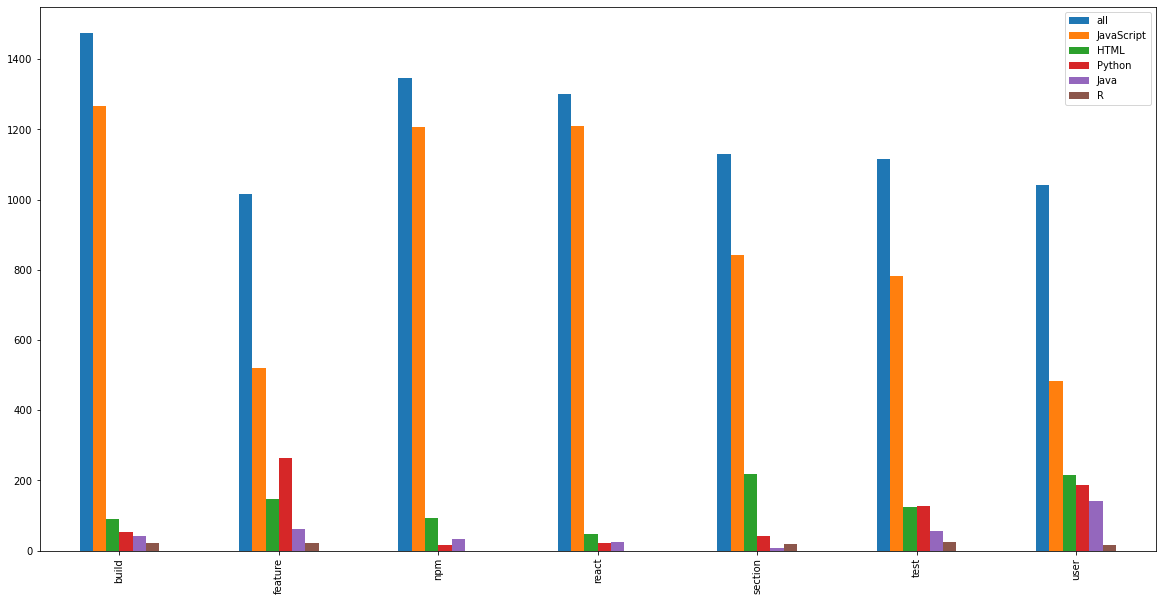

In [45]:
#incase we wanted to use the counts (can do with the 3 most_freq dfs, but I
#think we could skip this and just do the word_perc dfs for the graphs
#as I think they are more meaningful)
plt.rcParams["figure.figsize"] = (20,10)
most_freq.plot(kind='bar')

In [47]:
#transponsing dfs to make better graphs
word_perc_T = word_perc.T
word_perc_700_T = word_perc_700.T
word_perc_800_T = word_perc_800.T

to look at similarities, we simple look at bars w similar heights. That will show they have a similar distribution of that specific word

<AxesSubplot:>

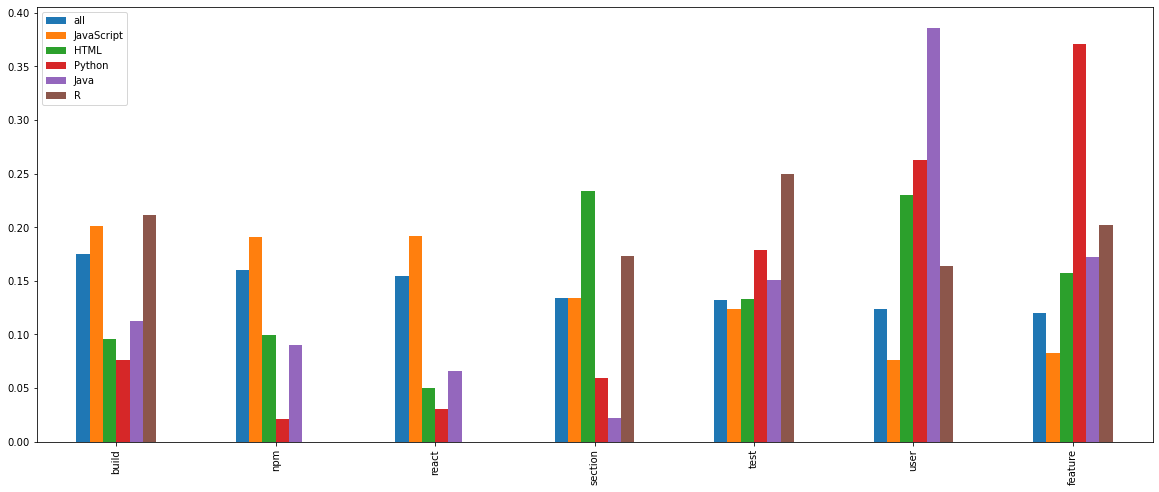

In [54]:
#the next 3 would make sense to do subplots. I'll make a function
#for them, I think we should get rid of all here too
plt.rcParams["figure.figsize"] = (20,8)
word_perc_T.plot(kind='bar')

<AxesSubplot:>

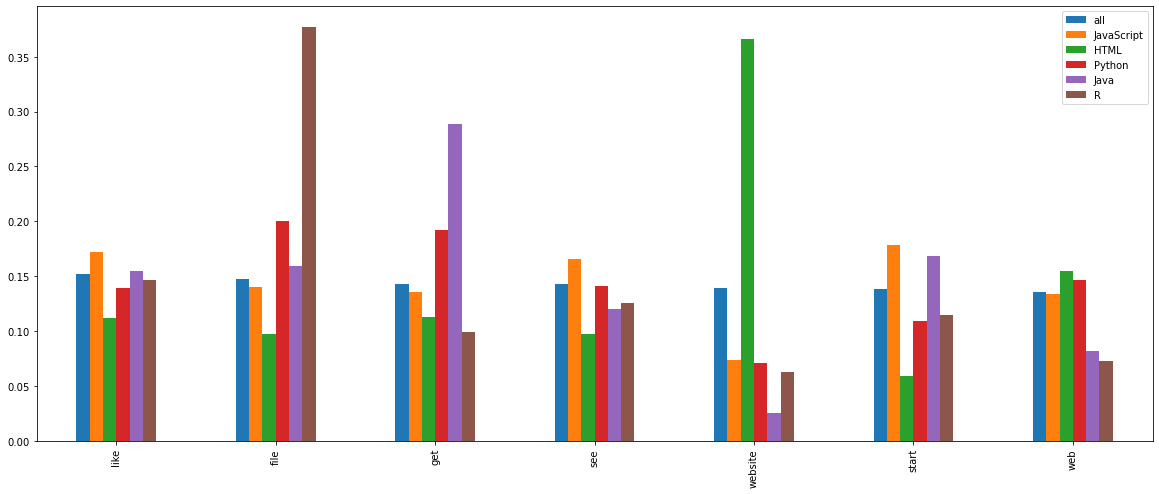

In [52]:
plt.rcParams["figure.figsize"] = (20,8)
word_perc_700_T.plot(kind='bar')

<AxesSubplot:>

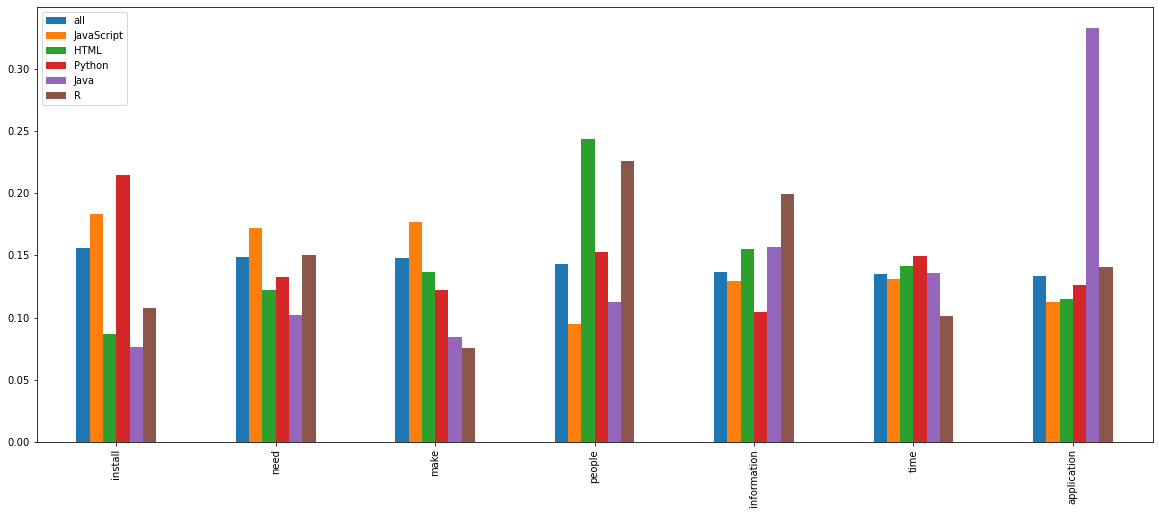

In [53]:
plt.rcParams["figure.figsize"] = (20,8)
word_perc_800_T.plot(kind='bar')

In [55]:
# I'm not sure about the bigrams and trigrams yet, but I think we hsould 
#include something about them
trigrams = [x for x in df['lemmatized'] for x in trigrams(x.split())]
trigrams

[('mental', 'health', 'datasetsthe'),
 ('health', 'datasetsthe', 'information'),
 ('datasetsthe', 'information', 'evolving'),
 ('information', 'evolving', 'list'),
 ('evolving', 'list', 'data'),
 ('list', 'data', 'set'),
 ('data', 'set', 'primarily'),
 ('set', 'primarily', 'electronicsocial'),
 ('primarily', 'electronicsocial', 'medium'),
 ('electronicsocial', 'medium', 'used'),
 ('medium', 'used', 'model'),
 ('used', 'model', 'mentalhealth'),
 ('model', 'mentalhealth', 'phenomenon'),
 ('mentalhealth', 'phenomenon', 'raw'),
 ('phenomenon', 'raw', 'data'),
 ('raw', 'data', 'additional'),
 ('data', 'additional', 'column'),
 ('additional', 'column', 'found'),
 ('column', 'found', 'datasourcesxlsx'),
 ('found', 'datasourcesxlsx', 'author'),
 ('datasourcesxlsx', 'author', 'paper'),
 ('author', 'paper', 'feel'),
 ('paper', 'feel', 'anything'),
 ('feel', 'anything', 'misrepresented'),
 ('anything', 'misrepresented', 'please'),
 ('misrepresented', 'please', 'hesitate'),
 ('please', 'hesitate',

In [57]:
#10 most common trigrams
top = tri_counts.most_common(10)
print (top)

[(('create', 'react', 'app'), 319), (('mental', 'health', 'issue'), 238), (('npm', 'run', 'build'), 193), (('information', 'npm', 'run'), 150), (('project', 'directory', 'run'), 108), (('app', 'development', 'modeopen'), 108), (('development', 'modeopen', 'httplocalhost3000httplocalhost3000'), 105), (('modeopen', 'httplocalhost3000httplocalhost3000', 'view'), 105), (('startruns', 'app', 'development'), 104), (('bootstrapped', 'create', 'react'), 103)]


In [58]:
#20 most common bis
top_20_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_bigrams.head(20)

(section, moved)                      527
(npm, install)                        206
(npm, build)                          205
(environment, variable)               195
(learn, react)                        181
(make, sure)                          175
(would, like)                         162
(production, build)                   160
(social, medium)                      156
(npm, start)                          153
(information, npm)                    152
(machine, learning)                   120
(getting, started)                    116
(test, runner)                        116
(html, cs)                            113
(configuration, file)                 111
(progressive, web)                    110
(build, tool)                         109
(httplocalhosthttplocalhost, view)    108
(build, fails)                        105
dtype: int64

# STOP HERE
### Lincoln is fixing models

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report


tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)


In [37]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 91.70%
---
Confusion Matrix
actual      HTML  Java  JavaScript  Python    R
predicted                                      
HTML         299    10           7       4    5
Java           0    72           0       0    0
JavaScript    15    31         470      16    4
Python         2     6           2     235    3
R              1     0           1       1  117
---
              precision    recall  f1-score   support

        HTML       0.92      0.94      0.93       317
        Java       1.00      0.61      0.75       119
  JavaScript       0.88      0.98      0.93       480
      Python       0.95      0.92      0.93       256
           R       0.97      0.91      0.94       129

    accuracy                           0.92      1301
   macro avg       0.94      0.87      0.90      1301
weighted avg       0.92      0.92      0.91      1301



In [47]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 62.88%
---
Confusion Matrix
actual      HTML  Java  JavaScript  Python   R
predicted                                     
HTML          49     3          14      10  14
Java           0     4           1       0   0
JavaScript    27    21         104      17   2
Python         3     2           1      36   5
R              0     0           0       1  12
---
              precision    recall  f1-score   support

        HTML       0.92      0.94      0.93       317
        Java       1.00      0.61      0.75       119
  JavaScript       0.88      0.98      0.93       480
      Python       0.95      0.92      0.93       256
           R       0.97      0.91      0.94       129

    accuracy                           0.92      1301
   macro avg       0.94      0.87      0.90      1301
weighted avg       0.92      0.92      0.91      1301



In [56]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

tree = DecisionTreeClassifier(max_depth=10, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_train, y_train) * 100:.2f}%')

Accuracy Score: 68.95%


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn import tree

In [75]:
cv = CountVectorizer()
X = cv.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

tree = DecisionTreeClassifier(max_depth=10, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_test, y_test) * 100:.2f}%')

Accuracy Score: 57.98%


In [67]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

tree = DecisionTreeClassifier(max_depth=8, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_test, y_test) * 100:.2f}%')

Accuracy Score: 44.79%


In [ ]:
cv = CountVectorizer(ngram_range=(3, 3))
X = cv.fit_transform(df.stemmed)
y = df.language

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

tree = DecisionTreeClassifier(max_depth=10, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_train, y_train) * 100:.2f}%')

In [ ]:
qfjwaivchE3

In [ ]:
all_words = re.sub(r'[^\w\s]', '', (' '.join(df.lemmatized))).split()
all_freq = pd.Series(all_words).value_counts()
    
    mask = all_freq > 1
    all_not_unique = list(all_freq[mask].index)

In [ ]:
bigrams = df.apply(lambda x : list(nltk.ngrams(x, 2)))

In [ ]:
bigrams

In [ ]:
def make_word_list(df):
    """ creates a list of every not unique word in dataframe"""
    all_words = re.sub(r'[^\w\s]', '', (' '.join(df.lemmatized))).split()
    all_freq = pd.Series(all_words).value_counts()
    
    mask = all_freq > 1
    all_not_unique = list(all_freq[mask].index)
    
    return all_not_unique

def finding_non_single_words(x):
    """finds all words in column that appear in df more than one time
    will be used to make a column that counts words that appear more than once"""
    all_not_unique = make_word_list(df)
    l = []
    for w in x:
        if w in all_not_unique:
            l.append(w)
    return l


def feature_engineering(df):
    """creates calculated columns for df subsetted by type of column"""
    
    #list making features 
    df['word_list'] = df.lemmatized.apply(lambda x: re.sub(r'[^\w\s]', '', x).split())
    df['unique_words'] = df.word_list.apply(lambda x: pd.Series(x).unique())
    df['non_single_words'] = df.word_list.apply(lambda x: finding_non_single_words(x))

    # counting
    df['word_count_simple'] = df.lemmatized.str.count(" ") + 1
    df['word_count'] = df.word_list.apply(lambda x: len(x))
    df['unique_count'] = df.unique_words.apply(lambda x: len(x))
    df['non_single_count'] = df.non_single_words.apply(lambda x: len(x))

    # calculating
    df['percent_unique'] = (df.unique_count / df.word_count)
    df['percent_repeat'] = (1 - df.unique_count / df.word_count)
    df['percent_one_word'] = df.word_list.apply(lambda x: (pd.Series(x).value_counts() == 1).mean())
    df['percent_non_single'] = (df.non_single_count / df.word_count)

    return df

# new dataframes

def language_series(df):
    """makes df with words and frequency of words for each programming language"""

    all_words = (' '.join(df.lemmatized))
    all_words = re.sub(r'[^\w\s]', '', all_words).split()
    all_freq = pd.Series(all_words).value_counts()

    php_words = (' '.join(df[df.language == 'PHP'].lemmatized))
    php_words = re.sub(r'[^\w\s]', '', php_words).split()
    php_freq = pd.Series(php_words).value_counts()

    python_words = (' '.join(df[df.language == 'Python'].lemmatized))
    python_words = re.sub(r'[^\w\s]', '', python_words).split()
    python_freq = pd.Series(python_words).value_counts()

    java_words = (' '.join(df[df.language == 'Java'].lemmatized))
    java_words = re.sub(r'[^\w\s]', '', java_words).split()
    java_freq = pd.Series(java_words).value_counts()

    js_words = (' '.join(df[df.language == 'JavaScript'].lemmatized))
    js_words = re.sub(r'[^\w\s]', '', js_words).split()
    js_freq = pd.Series(js_words).value_counts()

    freq_df = pd.DataFrame({'all': all_freq,
                       'php': php_freq,
                       'python': python_freq,
                       'java': java_freq,
                       'java_script': js_freq
                        })
    freq_df = freq_df.fillna(0)
    freq_df = freq_df.astype(int)

    return freq_df

def make_language_df(df=df):
    """creates a data frame of words in rows"""
    freq_df = language_series(df)
    
    freq_list = freq_df['all'].sort_values(ascending = False).head(15).index
    
    df_js = df[0:200]
    df_python = df[200:400]
    df_java = df[400:600]
    df_php= df[600:800]
    
    all_list = []
    js_list = []
    python_list = []
    php_list = []
    java_list = []
    
    for i in freq_list:
        v = len(pd.DataFrame({'loc_index' :df[df.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        all_list.append(v)
    
        js = len(pd.DataFrame({'loc_index' :df_js[df_js.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        js_list.append(js)
   
        py = len(pd.DataFrame({'loc_index' :df_python[df_python.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        python_list.append(py)
    
        php = len(pd.DataFrame({'loc_index' :df_php[df_php.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        php_list.append(php)
    
        jv = len(pd.DataFrame({'loc_index' :df_java[df_java.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        java_list.append(jv)
        
    language_df = pd.DataFrame({'word': freq_list,
                         'all_languages': all_list,
                        'javascript': js_list,
                         'python': python_list,
                        'php': php_list,
                            'java': java_list
                        })
        
    return language_df